## Install dependencies and import

In [2]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

Mounted at /content/gdrive


In [3]:
!pip install numpy
!pip install torch
!pip install matplotlib
!pip install scipy
!pip install torchvision
!pip install tqdm -U
!pip install visdom
!pip install nibabel
!pip install scikit-image
!pip install h5py
!pip install pandas
!pip install dominate
!pip install pydicom
!pip install opencv-python
!pip install scikit-learn
!pip install tensorflow
!pip install https://github.com/ozan-oktay/torchsample/tarball/master#egg=torchsample-0.1.3
!pip install git+https://github.com/baldassarreFe/pytorch-densenet-tiramisu

     |████████████████████████████████| 61kB 1.9MB/s 
  Found existing installation: tqdm 4.28.1
    Uninstalling tqdm-4.28.1:
      Successfully uninstalled tqdm-4.28.1


     |████████████████████████████████| 686kB 2.8MB/s 
     |████████████████████████████████| 204kB 41.5MB/s 
  Created wheel for visdom: filename=visdom-0.1.8.9-cp36-none-any.whl size=655252 sha256=d46996e029643b57be423018c017b68b213c69d1ae26dd646c4b14a0feb7cec7
  Stored in directory: /root/.cache/pip/wheels/70/19/a7/6d589ed967f4dfefd33bc166d081257bd4ed0cb618dccfd62a
  Created wheel for torchfile: filename=torchfile-0.1.0-cp36-none-any.whl size=5711 sha256=8b724ce4681f65ef4309efcb2263c8d657b8201f4fb0c39ac7c1436182d74b12
  Stored in directory: /root/.cache/pip/wheels/b1/c3/d6/9a1cc8f3a99a0fc1124cae20153f36af59a6e683daca0a0814
Successfully built visdom torchfile
     |████████████████████████████████| 35.1MB 84kB/s 
     \ 389kB 4.0MB/s
  Created wheel for torchsample: filename=torchsample-0.1.3-cp36-none-any.whl size=45258 sha256=96fc8e80f4013b16cbefe03260e3c05f42e753957204361e4380046d3c97de47
  Stored in directory: /tmp/pip-ephem-wheel-cache-gp2vp850/wheels/c2/f9/43/f2601da3bddeee29b

In [4]:
import os
import shutil
import zipfile
import json
import collections
import torch.nn as nn
import torch
import torchvision
import torchvision.transforms as T
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import pydicom
import numpy as np
import pandas as pd
import torch.optim as optim
from tqdm.notebook import tqdm
from torch.utils.tensorboard import SummaryWriter
import matplotlib.pyplot as plt
import numbers
import PIL
print("PyTorch Version: ",torch.__version__)
print("Torchvision Version: ",torchvision.__version__)

PyTorch Version:  1.3.1
Torchvision Version:  0.4.2


## Setup dataset

In [0]:
# local machine directories
DATA_DIR = "/content/data/"
DATA_MASKS_DIR = DATA_DIR + "masks"
DATA_DICOM_DIR = DATA_DIR + "input"

# google drive directories
DATA_ZIP_FILE_PATH = "/content/gdrive/My Drive/mlmi/dataset/input.zip"
MASKS_DIR = "/content/gdrive/My Drive/mlmi/dataset/masks/"
TENSORBOARD_LOGS_DIR = "/content/gdrive/My Drive/mlmi/results/tensorboard/"
MODEL_SAVE_DIR = "/content/gdrive/My Drive/mlmi/results/model/"


Copy masks from gdrive

In [6]:
# create data directory locally
if os.path.exists(DATA_DIR) == False:
  os.makedirs(DATA_DIR)
  print("Create directory: " + DATA_DIR)

if os.path.exists(DATA_MASKS_DIR):
  shutil.rmtree(DATA_MASKS_DIR)
  print("Deleted old masks directory: " + DATA_MASKS_DIR)

!cp -r "$MASKS_DIR" $DATA_DIR
%ls $DATA_MASKS_DIR

Create directory: /content/data/
simm_DS_test.csv  simm_DS_train.csv  simm_DS_validation.csv  train-rle.csv


In [0]:
## uncomment this code to reduce the train set size
# includeImagesCounts = 50
# trainSetCsv = pd.read_csv(DATA_MASKS_DIR + '/simm_DS_train.csv')
# tsReduced = trainSetCsv[:includeImagesCounts]
# tsReduced[:5]

# tsReduced.to_csv(DATA_MASKS_DIR + '/simm_DS_train.csv', index = None, header=True)

Extract DICOM files from zip

In [8]:
# only extract if input folder doesn't exists
if os.path.exists(DATA_DICOM_DIR) == False:
  #!unzip "$DATA_ZIP_FILE_PATH" -d "$DATA_DIR"
  zip_ref = zipfile.ZipFile(DATA_ZIP_FILE_PATH, 'r')
  zip_ref.extractall(DATA_DIR)
  zip_ref.close()
  print("Extracted dicom zip file to directory: " + DATA_DICOM_DIR)

%ls $DATA_DICOM_DIR
#%ls "$DATA_DICOM_DIR/siim/dicom-images-train"

Extracted dicom zip file to directory: /content/data/input
siim/


## Model Definitions

In [0]:
def rle2mask(rle, width, height):
    mask= np.zeros(width* height)
    array = np.asarray([int(x) for x in rle.split()])
    starts = array[0::2]
    lengths = array[1::2]

    current_position = 0
    for index, start in enumerate(starts):
        current_position += start
        mask[current_position:current_position+lengths[index]] = 255
        current_position += lengths[index]

    return mask.reshape(width, height)
    
class SIMMDataset(Dataset):
    """SIMM dataset."""

    def __init__(self, root_dir, split, transform=None):
        """
        Args:
            dicomPaths (Array<string>): Array of DICOM file Paths.
            mask_csv_file (string): csv file with encoded masks (rle).
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """

        self.root_dir = root_dir
        self.dir_postfix = 'input/siim/'

        self.im_height = 1024
        self.im_width = 1024
        self.im_chan = 1

        ## Read masks file
        mask_csv_file = root_dir + 'masks/train-rle.csv' 
        print("Reading masks from: " + mask_csv_file)
        self.encodedMasks = pd.read_csv(mask_csv_file, names=['ImageId', 'EncodedPixels'], index_col='ImageId')

        ## Read dataset file names
        dsFile = root_dir + 'masks/simm_DS_' + split + '.csv'
        print("Reading ds from: " + dsFile)
        dsFileData = pd.read_csv(dsFile)
        self.dicomPaths = dsFileData['path'].tolist()
        # print("READ")
        self.transform = transform

    def __len__(self):
        return len(self.dicomPaths)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        # Read dicom file
        dPath = self.dicomPaths[idx]
        dicom = pydicom.dcmread(self.root_dir + self.dir_postfix + dPath)
        
        # get image from dicom to numpy array
        image = np.array(dicom.pixel_array)
        
        # get mask (in rle) from csv
        landmarks = np.zeros((self.im_height, self.im_width), dtype=np.bool)
        
        fileId = dPath.split('/')[-1][:-4]
        rle = self.encodedMasks.loc[fileId, 'EncodedPixels']
        try:
            if type(rle) == str: # if single rle
                decodedRle = rle2mask(rle, self.im_height, self.im_width)
#                 landmarks = np.expand_dims(decodedRle, axis=2)
                landmarks = decodedRle
            else: # if multiple rle
                for x in rle:
                    decodedRle = rle2mask(x, self.im_height, self.im_width)
                    landmarks = landmarks + decodedRle
#                     landmarks = landmarks + np.expand_dims(decodedRle, axis=2)
        except Exception as e:
            print(e)
            
        #### TODO - IMPORTANT::: CHECK THIS  
        ## QUESTION: SHOULD WE TRANSPOSE THE MASK IN THE GETITEM FUNCTION 
        ## BECAUSE WHEN PLOTING THE GRAPHS WE HAVE TO TRANSPOSE IT.
        landmarks = landmarks.T

        # for some images, we have multiple masks, so we are adding the masks
        # which results in some pixels to > 1
        landmarks = (landmarks >= 1).astype('float32')

        image = np.array(image)
        landmarks = np.array(landmarks)

        # converting numpy array to PIL image
        image = PIL.Image.fromarray(image)
        landmarks = PIL.Image.fromarray(landmarks)

        size = (224, 224)
        image = image.resize(size, PIL.Image.BILINEAR)
        landmarks = landmarks.resize(size, PIL.Image.BILINEAR)

        if self.transform:
          # torchvision transforms needs PIL image
          # apply transformation
          image, landmarks = self.transform(image, landmarks)

        # convert image to 3 channel
        image = image.convert('RGB')

        # converting back to numpy array from PIL image
        image = np.array(image)
        landmarks = np.array(landmarks)

        # swap color axis because
        # numpy image: H x W x C
        # but torch image: C X H X W
        image = np.transpose(image, (2, 0, 1))

        # image = np.expand_dims(image, axis=0)

        landmarks = np.expand_dims(landmarks, axis=0)

        # normalize image to 0-1
        image = image / 255

        return image, landmarks

In [0]:
class GridAttentionBlock2D(nn.Module):
    def __init__(self, in_channels, gating_channels, inter_channels=None, dimension=2, mode='concatenation', sub_sample_factor=(2,2,2)):
        super(GridAttentionBlock2D, self).__init__()

        assert dimension in [2]
        assert mode in ['concatenation']

        # Downsampling rate for the input featuremap
        if isinstance(sub_sample_factor, tuple): self.sub_sample_factor = sub_sample_factor
        elif isinstance(sub_sample_factor, list): self.sub_sample_factor = tuple(sub_sample_factor)
        else: self.sub_sample_factor = tuple([sub_sample_factor]) * dimension

        # Default parameter set
        self.mode = mode
        self.dimension = dimension
        self.sub_sample_kernel_size = self.sub_sample_factor

        # Number of channels (pixel dimensions)
        self.in_channels = in_channels
        self.gating_channels = gating_channels
        self.inter_channels = inter_channels

        if self.inter_channels is None:
            self.inter_channels = in_channels // 2
            if self.inter_channels == 0:
                self.inter_channels = 1

        if dimension == 2:
            conv_nd = nn.Conv2d
            bn = nn.BatchNorm2d
            self.upsample_mode = 'bilinear'
        else:
            raise NotImplemented

        # Output transform
        self.W = nn.Sequential(
            conv_nd(in_channels=self.in_channels, out_channels=self.in_channels, kernel_size=1, stride=1, padding=0),
            bn(self.in_channels),
        )

        # Theta^T * x_ij + Phi^T * gating_signal + bias
        self.theta = conv_nd(in_channels=self.in_channels, out_channels=self.inter_channels,
                             kernel_size=self.sub_sample_kernel_size, stride=self.sub_sample_factor, padding=0, bias=False)
        self.phi = conv_nd(in_channels=self.gating_channels, out_channels=self.inter_channels,
                           kernel_size=1, stride=1, padding=0, bias=True)
        self.psi = conv_nd(in_channels=self.inter_channels, out_channels=1, kernel_size=1, stride=1, padding=0, bias=True)

        # Initialise weights
        for m in self.children():
            init_weights(m, init_type='kaiming')

        # Define the operation
        if mode == 'concatenation':
            self.operation_function = self._concatenation
        else:
            raise NotImplementedError('Unknown operation function.')


    def forward(self, input, gating_signal):
        '''
        :param x: (b, c, t, h, w)
        :param g: (b, g_d)
        :return:
        '''
        output = self.operation_function(input, gating_signal)
        return output

    def _concatenation(self, x, g):
        input_size = x.size()
        batch_size = input_size[0]
        assert batch_size == g.size(0)

        # theta => (b, c, t, h, w) -> (b, i_c, t, h, w) -> (b, i_c, thw)
        # phi   => (b, g_d) -> (b, i_c)
        theta_x = self.theta(x)
        theta_x_size = theta_x.size()

        # g (b, c, t', h', w') -> phi_g (b, i_c, t', h', w')
        #  Relu(theta_x + phi_g + bias) -> f = (b, i_c, thw) -> (b, i_c, t/s1, h/s2, w/s3)
        phi_g = F.interpolate(self.phi(g), size=theta_x_size[2:], mode=self.upsample_mode)
        f = F.relu(theta_x + phi_g, inplace=True)

        #  psi^T * f -> (b, psi_i_c, t/s1, h/s2, w/s3)
        sigm_psi_f = torch.sigmoid(self.psi(f))

        # upsample the attentions and multiply
        sigm_psi_f = F.interpolate(sigm_psi_f, size=input_size[2:], mode=self.upsample_mode)
        y = sigm_psi_f.expand_as(x) * x
        W_y = self.W(y)

        # gate, attention
        return W_y, sigm_psi_f

In [0]:
from dense import DenseLayer, DenseBlock, TransitionUp, TransitionDown
from torch.nn import Module, Conv2d, BatchNorm2d, Linear, init
from torch.nn import Sequential
from typing import Optional, Sequence, Union

## https://github.com/baldassarreFe/pytorch-densenet-tiramisu
class FCDenseNet(Module):
    def __init__(self,
                 in_channels: int = 3,
                 out_channels: int = 1,
                 initial_num_features: int = 48,
                 dropout: float = 0.2,

                 down_dense_growth_rates: Union[int, Sequence[int]] = 16,
                 down_dense_bottleneck_ratios: Union[Optional[int], Sequence[Optional[int]]] = None,
                 down_dense_num_layers: Union[int, Sequence[int]] = (4, 5, 7, 10, 12),
                 down_transition_compression_factors: Union[float, Sequence[float]] = 1.0,

                 middle_dense_growth_rate: int = 16,
                 middle_dense_bottleneck: Optional[int] = None,
                 middle_dense_num_layers: int = 15,

                 up_dense_growth_rates: Union[int, Sequence[int]] = 16,
                 up_dense_bottleneck_ratios: Union[Optional[int], Sequence[Optional[int]]] = None,
                 up_dense_num_layers: Union[int, Sequence[int]] = (12, 10, 7, 5, 4)):
      
        super(FCDenseNet, self).__init__()

        # region Parameters handling
        self.in_channels = in_channels
        self.out_channels = out_channels

        if type(down_dense_growth_rates) == int:
            down_dense_growth_rates = (down_dense_growth_rates,) * 5
        if down_dense_bottleneck_ratios is None or type(down_dense_bottleneck_ratios) == int:
            down_dense_bottleneck_ratios = (down_dense_bottleneck_ratios,) * 5
        if type(down_dense_num_layers) == int:
            down_dense_num_layers = (down_dense_num_layers,) * 5
        if type(down_transition_compression_factors) == float:
            down_transition_compression_factors = (down_transition_compression_factors,) * 5

        if type(up_dense_growth_rates) == int:
            up_dense_growth_rates = (up_dense_growth_rates,) * 5
        if up_dense_bottleneck_ratios is None or type(up_dense_bottleneck_ratios) == int:
            up_dense_bottleneck_ratios = (up_dense_bottleneck_ratios,) * 5
        if type(up_dense_num_layers) == int:
            up_dense_num_layers = (up_dense_num_layers,) * 5
        # endregion

        # region First convolution
        self.features = Conv2d(in_channels, initial_num_features, kernel_size=3, padding=1, bias=False)
        current_channels = self.features.out_channels
        # endregion

        # region Downward path
        # Pairs of Dense Blocks with input concatenation and TransitionDown layers
        down_dense_params = [
            {
                'concat_input': True,
                'growth_rate': gr,
                'num_layers': nl,
                'dense_layer_params': {
                    'dropout': dropout,
                    'bottleneck_ratio': br
                }
            }
            for gr, nl, br in
            zip(down_dense_growth_rates, down_dense_num_layers, down_dense_bottleneck_ratios)
        ]

        down_transition_params = [
            {
                'dropout': dropout,
                'compression': c
            } for c in down_transition_compression_factors
        ]

        skip_connections_channels = []

        self.down_dense = Module()
        self.down_trans = Module()

        down_pairs_params = zip(down_dense_params, down_transition_params)
        for i, (dense_params, transition_params) in enumerate(down_pairs_params):
            block = DenseBlock(current_channels, **dense_params)
            current_channels = block.out_channels
            self.down_dense.add_module(f'block_{i}', block)

            skip_connections_channels.append(block.out_channels)

            transition = TransitionDown(current_channels, **transition_params)
            current_channels = transition.out_channels
            self.down_trans.add_module(f'trans_{i}', transition)
        # endregion

        # region Middle block
        # Renamed from "bottleneck" in the paper, to avoid confusion with the Bottleneck of DenseLayers
        self.middle = DenseBlock(
            current_channels,
            middle_dense_growth_rate,
            middle_dense_num_layers,
            concat_input=True,
            dense_layer_params={
                'dropout': dropout,
                'bottleneck_ratio': middle_dense_bottleneck
            })
        current_channels = self.middle.out_channels
        # endregion

        # region Upward path
        # Pairs of TransitionUp layers and Dense Blocks without input concatenation
        up_transition_params = [
            {
                'skip_channels': sc,
            } for sc in reversed(skip_connections_channels)
        ]
        up_dense_params = [
            {
                'concat_input': False,
                'growth_rate': gr,
                'num_layers': nl,
                'dense_layer_params': {
                    'dropout': dropout,
                    'bottleneck_ratio': br
                }
            }
            for gr, nl, br in
            zip(up_dense_growth_rates, up_dense_num_layers, up_dense_bottleneck_ratios)
        ]

        self.up_dense = Module()
        self.up_trans = Module()
        up_pairs_params = zip(up_transition_params, up_dense_params)
        for i, (transition_params_up, dense_params_up) in enumerate(up_pairs_params):
            transition = TransitionUp(current_channels, **transition_params_up)
            current_channels = transition.out_channels
            self.up_trans.add_module(f'trans_{i}', transition)

            block = DenseBlock(current_channels, **dense_params_up)
            current_channels = block.out_channels
            self.up_dense.add_module(f'block_{i}', block)
        # endregion

        # region Final convolution
        self.final = Conv2d(current_channels, out_channels, kernel_size=1, bias=False)
        # endregion

        # region Weight initialization
        for module in self.modules():
            if isinstance(module, Conv2d):
                init.kaiming_normal_(module.weight)
            elif isinstance(module, BatchNorm2d):
                module.reset_parameters()
            elif isinstance(module, Linear):
                init.xavier_uniform_(module.weight)
                init.constant_(module.bias, 0)
        # endregion

    def forward(self, x):
        res = self.features(x)

        skip_tensors = []
        for dense, trans in zip(self.down_dense.children(), self.down_trans.children()):
            res = dense(res)
            skip_tensors.append(res)
            res = trans(res)

        res = self.middle(res)

        for skip, trans, dense in zip(reversed(skip_tensors), self.up_trans.children(), self.up_dense.children()):
            res = trans(res, skip)
            res = dense(res)

        res = self.final(res)

        return torch.sigmoid(res)

    # def predict(self, x):
    #     logits = self(x)
    #     return F.softmax(logits)

In [0]:
# model to use
class FCDenseNet103(FCDenseNet):
    def __init__(self, in_channels=3, out_channels=1000, dropout=0.0):
        super(FCDenseNet103, self).__init__(
            in_channels=in_channels,
            out_channels=out_channels,
            initial_num_features=48,
            dropout=dropout,

            down_dense_growth_rates=16,
            down_dense_bottleneck_ratios=None,
            down_dense_num_layers=(4, 5, 7, 10, 12),
            down_transition_compression_factors=1.0,

            middle_dense_growth_rate=16,
            middle_dense_bottleneck=None,
            middle_dense_num_layers=15,

            up_dense_growth_rates=16,
            up_dense_bottleneck_ratios=None,
            up_dense_num_layers=(12, 10, 7, 5, 4)
        )

In [0]:
class SIMMSoftDiceLoss(nn.Module):
    def __init__(self):
        super(SIMMSoftDiceLoss, self).__init__()

    def forward(self, input, target):
        smooth = 0.01
        batch_size = input.size(0)

        # input = torch.sigmoid(input).view(batch_size, -1)
        input = input.view(batch_size, -1)
        labels = target.contiguous().view(batch_size, -1)

        inter = torch.sum(input * labels, 1) + smooth
        union = torch.sum(input, 1) + torch.sum(labels, 1) + smooth

        score = torch.sum(2.0 * inter / union, 0)
        score = 1.0 - score / float(batch_size)

        # if score.item() > 1.0:
        #   print('loss greater than 1')
        #   print('prediction')
        #   print(torch.max(input))
        #   print(torch.min(input))
        #   print('target')
        #   print(torch.max(target))
        #   print(torch.min(target))
        
        return score

class SIMMHardDiceScore(nn.Module):
    def __init__(self):
        super(SIMMHardDiceScore, self).__init__()

    def forward(self, input, target):
        smooth = 0.01

        # convert input to hard classification
        hardClf = input.clone()
        hardClf[hardClf > 0.5] = 1
        hardClf[hardClf <= 0.5] = 0

        labels = target.clone()
        batch_size = hardClf.size(0)

        # input = torch.sigmoid(input).view(batch_size, -1)
        hardClf = hardClf.view(batch_size, -1)
        labels = labels.contiguous().view(batch_size, -1)

        inter = torch.sum(hardClf * labels, 1) + smooth
        union = torch.sum(hardClf, 1) + torch.sum(labels, 1) + smooth

        score = torch.sum(2.0 * inter / union, 0)
        score = score / float(batch_size)
        
        return score

class SIMMCrossEntropyLoss(nn.Module):
    def __init__(self):
        super(SIMMCrossEntropyLoss, self).__init__()
        self.BCE = nn.BCELoss()

    def forward(self, input, target):
        t = target.float()
        return self.BCE(input, t)

class SIMMDiceAndEntropyLoss(nn.Module):
    def __init__(self):
        super(SIMMDiceAndEntropyLoss, self).__init__()
        self.diceLoss = SIMMSoftDiceLoss()
        self.BCE = SIMMCrossEntropyLoss()

    def forward(self, input, target):
        bceLoss = self.BCE(input, target)
        dLoss = self.diceLoss(input, target)

        # print("bceLoss: " + str(bceLoss.item()) + ", dLoss: " + str(dLoss.item()))

        combinedLoss = 0.5 * bceLoss + 0.5 * dLoss

        # print("combinedLoss: " + str(combinedLoss.item()))
        
        return combinedLoss

In [0]:
def json_file_to_pyobj(jsonStr):
    def _json_object_hook(d): return collections.namedtuple('X', d.keys())(*d.values())
    def json2obj(data): return json.loads(data, object_hook=_json_object_hook)
    return json2obj(jsonStr)
    
def create_checkpoint(run_name, model, optimizer, is_best, epoch, network_options, train_loss, valid_loss, best_valid_loss):

  save_dir = os.path.join(MODEL_SAVE_DIR, run_name)
  if os.path.exists(save_dir) == False:
    os.makedirs(save_dir)
    print('Creating save dir: ' + save_dir)

  print('Saving model checkpoint at epoch: ' + str(epoch))
  state = {
      'run_name': run_name,
      'model_state': model.state_dict(),
      'optimizer_state': optimizer.state_dict(),
      'epoch': epoch,
      'rng_state': torch.get_rng_state(),
      'network_options': network_options,
      'train_loss': train_loss,
      'valid_loss': valid_loss,
      'best_valid_loss': best_valid_loss
  }

  torch.save(state, os.path.join(MODEL_SAVE_DIR, run_name, 'checkpoint.pt'))
  if is_best:
    torch.save(state, os.path.join(MODEL_SAVE_DIR, run_name, 'checkpoint_best.pt'))

def load_checkpoint(run_name, model, optimizer, load_best=False):
  ckh_path = os.path.join(MODEL_SAVE_DIR, run_name, 'checkpoint.pt')
  if load_best:
    ckh_path = os.path.join(MODEL_SAVE_DIR, run_name, 'checkpoint_best.pt')
  checkpoint = torch.load(ckh_path)
  model.load_state_dict(checkpoint['model_state'])
  optimizer.load_state_dict(checkpoint['optimizer_state'])
  torch.set_rng_state(checkpoint['rng_state'])

  return model, optimizer, checkpoint

def print_checkpoint(checkpoint):
  print("Run Name: " + str(checkpoint['run_name']))
  print("Last epoch: " + str(checkpoint['epoch']))
  print("Train Loss: " + str(checkpoint['train_loss']))
  print("Validation Loss: " + str(checkpoint['valid_loss']))
  print("Best Validation Loss: " + str(checkpoint['best_valid_loss']))
  print("Options: " + str(checkpoint['network_options']))


Transformations

In [0]:
class SegCompose(object):
    def __init__(self, transforms):
        self.transforms = transforms

    def __call__(self, image, target):
        for t in self.transforms:
            image, target = t(image, target)
        return image, target

class SegRandomAffine(object):
  def __init__(self, degrees, translate=None, scale=None, resample=False, fillcolor=0):
    # NOTE: shear is REMOVED FOR NOW

    # just to check the values using this contructor
    self.segTransform = T.RandomAffine(degrees, translate, scale, None, resample, fillcolor)

    if isinstance(degrees, numbers.Number):
        self.degrees = (-degrees, degrees)
    else:
        self.degrees = degrees
        
    self.translate = translate
    self.scale = scale
    self.resample = resample
    self.fillcolor = fillcolor

  def __call__(self, image, target):
        ret = T.RandomAffine.get_params(self.degrees, self.translate, self.scale, None, image.size)
        image = T.functional.affine(image, *ret, resample=self.resample, fillcolor=self.fillcolor)
        target = T.functional.affine(target, *ret, resample=self.resample, fillcolor=self.fillcolor)

        return image, target

class SegToTensor(object):
  def __init__(self):
    self.ToTensor = T.ToTensor()
  def __call__(self, image, target):
        image = self.ToTensor(image)
        target = self.ToTensor(target)

        return image, target

## Model Training

In [16]:
use_cuda = False
if torch.cuda.is_available():
  gpu_count = torch.cuda.device_count()
  print("Available GPU count:" + str(gpu_count))
  use_cuda = True
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

Available GPU count:1
cuda:0


In [0]:
## Model Hyperparameters

NETWORK_OPTIONS = dict()
NETWORK_OPTIONS['USE_CUDA'] = use_cuda

# Set to false if only need to run on train dataset
NETWORK_OPTIONS['USE_VAL_SET'] = True

# NETWORK_OPTIONS['LR_POLICY'] = "step"
# NETWORK_OPTIONS['LR_DECAY_ITERS'] = 25
NETWORK_OPTIONS['LR_RATE'] = 1e-4
NETWORK_OPTIONS['L2_REG_WEIGHT'] = 1e-6
NETWORK_OPTIONS['DROPOUT'] = 0.2

NETWORK_OPTIONS['BATCH_SIZE'] = 4

# dont forget to set run_name when continue_train is true
NETWORK_OPTIONS['CONTINUE_TRAIN'] = False
NETWORK_OPTIONS['LOAD_BEST'] = False
NETWORK_OPTIONS['RUN_NAME'] = ''
NETWORK_OPTIONS['START_EPOCH'] = 0
NETWORK_OPTIONS['NUM_EPOCHS'] = 100

# NETWORK_OPTIONS['FEATURE_SCALE'] = 2
# NETWORK_OPTIONS['DIVISION_FACTOR'] = 1

NETWORK_OPTIONS['DATALOADER_NUM_WORKERS'] = 1
NETWORK_OPTIONS['DATA_DIR'] = DATA_DIR
NETWORK_OPTIONS['TENSORBOARD_LOGS_DIR'] = TENSORBOARD_LOGS_DIR
NETWORK_OPTIONS['MODEL_SAVE_DIR'] = MODEL_SAVE_DIR

# converting dict() to python object (just for easy access)
NETWORK_OPTIONS_OBJ = json_file_to_pyobj(json.dumps(NETWORK_OPTIONS))

In [18]:
# Defining Dataloaders

rotate_val = 20.0
translation_val = [0.1,0.1]
scale_val = [0.7,1.3]

train_transform = SegCompose([
                              SegRandomAffine(degrees=rotate_val, translate=translation_val, scale=scale_val)
                             ])
train_transform = None

train_dataset = SIMMDataset(NETWORK_OPTIONS_OBJ.DATA_DIR, split='train', transform=train_transform)
valid_dataset = SIMMDataset(NETWORK_OPTIONS_OBJ.DATA_DIR, split='validation', transform=None)
test_dataset  = SIMMDataset(NETWORK_OPTIONS_OBJ.DATA_DIR, split='test', transform=None)

train_loader = DataLoader(dataset=train_dataset, num_workers=NETWORK_OPTIONS_OBJ.DATALOADER_NUM_WORKERS, batch_size=NETWORK_OPTIONS_OBJ.BATCH_SIZE, shuffle=True)
valid_loader = DataLoader(dataset=valid_dataset, num_workers=NETWORK_OPTIONS_OBJ.DATALOADER_NUM_WORKERS, batch_size=NETWORK_OPTIONS_OBJ.BATCH_SIZE, shuffle=False)
test_loader  = DataLoader(dataset=test_dataset,  num_workers=NETWORK_OPTIONS_OBJ.DATALOADER_NUM_WORKERS, batch_size=NETWORK_OPTIONS_OBJ.BATCH_SIZE, shuffle=False)

Reading masks from: /content/data/masks/train-rle.csv
Reading ds from: /content/data/masks/simm_DS_train.csv
Reading masks from: /content/data/masks/train-rle.csv
Reading ds from: /content/data/masks/simm_DS_validation.csv
Reading masks from: /content/data/masks/train-rle.csv
Reading ds from: /content/data/masks/simm_DS_test.csv


In [19]:
model = FCDenseNet103(in_channels=3,
                      out_channels=1,
                      dropout=NETWORK_OPTIONS_OBJ.DROPOUT)
print(model)

optimizer = optim.Adam(model.parameters(),
                        lr=NETWORK_OPTIONS_OBJ.LR_RATE,
                        betas=(0.9, 0.999),
                        weight_decay=NETWORK_OPTIONS_OBJ.L2_REG_WEIGHT)

# optimizer = optim.SGD(params,
#                               lr=option.lr_rate,
#                               momentum=0.9,
#                               nesterov=True,
#                               weight_decay=option.l2_reg_weight)

model = model.to(device)

FCDenseNet103(
  (features): Conv2d(3, 48, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (down_dense): Module(
    (block_0): DenseBlock(48, 4*16+48=112)(
      (layer_0): DenseLayer(48, 16)(
        (norm): BatchNorm2d(48, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv): Conv2d(48, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (drop): Dropout2d(p=0.2, inplace=True)
      )
      (layer_1): DenseLayer(64, 16)(
        (norm): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv): Conv2d(64, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (drop): Dropout2d(p=0.2, inplace=True)
      )
      (layer_2): DenseLayer(80, 16)(
        (norm): BatchNorm2d(80, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv): Conv2d(8

In [0]:
last_best_valid_loss = 100.0
if NETWORK_OPTIONS_OBJ.CONTINUE_TRAIN == True:
  run_name = NETWORK_OPTIONS_OBJ.RUN_NAME
  model, optimizer, checkpoint = load_checkpoint(run_name, model, optimizer, load_best=NETWORK_OPTIONS_OBJ.LOAD_BEST)
  last_best_valid_loss = checkpoint['best_valid_loss']
  print_checkpoint(checkpoint)

In [0]:
def show_images_with_masks_and_prediction(images, labels, predictions):
  # create grid of images
  img_grid = torchvision.utils.make_grid(images.clone().cpu())
  target_grid = torchvision.utils.make_grid(labels.clone().cpu())
  prediction_grid = torchvision.utils.make_grid(predictions.clone().cpu())
  # print(img_grid.shape)

  img_grid = np.transpose(img_grid.numpy(), (1, 2, 0))
  target_grid = np.transpose(target_grid.numpy(), (1, 2, 0))
  prediction_grid = np.transpose(prediction_grid.numpy(), (1, 2, 0))


  mask_target = (target_grid == [1.,1.,1.]).all(axis=2)
  target_grid[mask_target] = [1, 0, 0]


  mask_pred = (prediction_grid == [1.,1.,1.]).all(axis=2)
  prediction_grid[mask_pred] = [0, 0, 1]

  plt.figure()
  plt.imshow(img_grid, cmap=plt.cm.bone)
  plt.imshow(target_grid, alpha=0.3)
  plt.imshow(prediction_grid, alpha=0.3)
  plt.show()

def show_images_with_masks(images, labels):
  # create grid of images
  img_grid = torchvision.utils.make_grid(images.clone().cpu())
  target_grid = torchvision.utils.make_grid(labels.clone().cpu())
  # print(img_grid.shape)

  img_grid = np.transpose(img_grid.numpy(), (1, 2, 0))
  target_grid = np.transpose(target_grid.numpy(), (1, 2, 0))

  # print(target_grid.shape)
  mask_target = (target_grid == [1.,1.,1.]).all(axis=2)
  target_grid[mask_target] = [1, 0, 0]

  plt.figure()
  plt.imshow(img_grid, cmap=plt.cm.bone)
  plt.imshow(target_grid, alpha=0.3)
  plt.show()

torch.Size([4, 3, 224, 224])
torch.Size([4, 1, 224, 224])


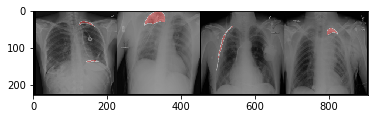

In [22]:
dataiter = iter(train_loader)
sample_images, sample_labels = dataiter.next()

print(sample_images.shape)
print(sample_labels.shape)

show_images_with_masks(sample_images, sample_labels)

In [23]:
%load_ext tensorboard
%tensorboard --logdir="$NETWORK_OPTIONS_OBJ.TENSORBOARD_LOGS_DIR"
# %reload_ext tensorboard
# import time
# time.sleep(10)

In [0]:
torch.cuda.empty_cache()

In [0]:
criterion = SIMMSoftDiceLoss()
DiceScore = SIMMHardDiceScore()

In [0]:
import time
timestr = time.strftime("%Y_%m_%d-%H_%M_%S")

run_prefix = 'fcdn103'
run_name = timestr
if NETWORK_OPTIONS_OBJ.CONTINUE_TRAIN == True:
  run_name = NETWORK_OPTIONS_OBJ.RUN_NAME
print(run_name)

tb_log_dir = NETWORK_OPTIONS_OBJ.TENSORBOARD_LOGS_DIR + run_prefix + '_' + run_name
tb = SummaryWriter(flush_secs=10, log_dir=tb_log_dir)

# criterion = SIMMSoftDiceLoss()
best_train_loss = 100.0
best_valid_loss = 100.0

if NETWORK_OPTIONS_OBJ.CONTINUE_TRAIN == False:
  tb.add_scalar("learning_rate", NETWORK_OPTIONS_OBJ.LR_RATE)
  tb.add_scalar("batch_size", NETWORK_OPTIONS_OBJ.BATCH_SIZE)
  # tb.add_scalar("feature_scale", NETWORK_OPTIONS_OBJ.FEATURE_SCALE)
  # tb.add_image('siim_sample_images', img_grid)
  tb.add_text('run_name', run_name)
  # tb.add_hparams(NETWORK_OPTIONS)
else:
  best_valid_loss = last_best_valid_loss


tb.add_graph(model, sample_images.float().to(device))

tb.flush()

# Training loop
for epoch in range(NETWORK_OPTIONS_OBJ.START_EPOCH, NETWORK_OPTIONS_OBJ.START_EPOCH + NETWORK_OPTIONS_OBJ.NUM_EPOCHS):
  time.sleep(0.1)
  print('############# Running epoch: %d...\n' % (epoch))

  ## Training Iterations

  model.train()

  running_loss = 0.0
  loss_per_epoch = 0.0
  dice_score_per_epoch = 0.0
  epoch_batch_count = 0

  total_iter = total=len(train_loader)
  for epoch_iter, (images, labels) in tqdm(enumerate(train_loader, 1), total=total_iter):
    # Make a training update
    inputs = images.float().to(device)
    masks = labels.to(device)
    # assert input.size() == target.size()

    # print('img: ' + str(inputs.dtype))
    # print('lnd: ' + str(inputs.dtype))

    # forward + backward + optimize
    outputs = model(inputs)
    # print(outputs.shape)
    loss = criterion(outputs, masks)

    # zero the parameter gradients
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    # calculate dice score
    dScore = DiceScore(outputs, masks)

    # update losses for epoch
    loss_per_epoch += loss.item()
    dice_score_per_epoch += dScore.item()
    epoch_batch_count += 1
    # print statistics
    running_loss += loss.item()
    if epoch_iter % 20 == 0:
      #show_images_with_masks_and_prediction(images, labels, outputs)
      loss_avg = running_loss / 20
      #print('[%d, %5d] Running loss: %.3f' % (epoch + 1, epoch_iter + 1, loss_avg))
      # (10 * x + y) / 10
      i_num = (epoch + 1) + ((epoch_iter + 1) / total_iter)
      tb.add_scalar('RunningLoss', loss_avg, i_num)
      running_loss = 0.0

  loss = loss_per_epoch / epoch_batch_count
  dice_score_per_epoch = dice_score_per_epoch / epoch_batch_count
  tb.add_scalar('Loss', loss, epoch + 1)
  tb.add_scalar('DiceScore', dice_score_per_epoch, epoch + 1)
  print('*********** [%d] Loss per epoch: %.3f' %(epoch + 1, loss))
  print('*********** [%d] Dice Score per epoch: %.3f' %(epoch + 1, dice_score_per_epoch))

  if loss <= best_train_loss:
    best_train_loss = loss

  # Validation Iterations

  model.eval()

  running_loss_valid = 0.0
  loss_per_epoch_valid = 0.0
  dice_score_per_epoch_valid = 0.0
  epoch_batch_count_valid = 0
  loss_valid = 100
  if NETWORK_OPTIONS_OBJ.USE_VAL_SET:
    with torch.no_grad():
      total_valid_iter = total=len(valid_loader)
      for epoch_iter, (images, labels) in tqdm(enumerate(valid_loader, 1), total=total_valid_iter):
        # get batch
        inputs = images.float().to(device)
        masks = labels.to(device)
        # assert input.size() == target.size()

        # forward
        outputs = model(inputs)
        loss = criterion(outputs, masks)

        # calculate dice score
        dScore = DiceScore(outputs, masks)

        # update losses for epoch
        loss_per_epoch_valid += loss.item()
        dice_score_per_epoch_valid += dScore.item()
        epoch_batch_count_valid += 1
        running_loss_valid += loss.item()

        if epoch_iter % 20 == 0:
          loss_avg = running_loss_valid / 20
          # print('[%d, %5d] Running loss Validation: %.3f' % (epoch + 1, epoch_iter + 1, loss_avg))
          # (10 * x + y) / 10
          # i_num = (10 * (epoch + 1) + (epoch_iter + 1)) - 10
          i_num = (epoch + 1) + ((epoch_iter + 1) / total_valid_iter)
          tb.add_scalar('RunningLossValidation', loss_avg, i_num)
          running_loss_valid = 0.0

    loss_valid = loss_per_epoch_valid / epoch_batch_count_valid
    dice_score_per_epoch_valid = dice_score_per_epoch_valid / epoch_batch_count_valid
    tb.add_scalar('LossValidation', loss_valid, epoch + 1)
    tb.add_scalar('DiceScoreValidation', dice_score_per_epoch_valid, epoch + 1)
    print('*********** [%d] Validation Loss per epoch: %.3f' %(epoch + 1, loss_valid))
    print('*********** [%d] Validation DiceScore per epoch: %.3f' %(epoch + 1, dice_score_per_epoch_valid))


  is_best = False
  if loss_valid < best_valid_loss:
    best_valid_loss = loss_valid
    is_best = True

  create_checkpoint(run_name, model, optimizer, is_best, epoch, NETWORK_OPTIONS, loss, loss_valid, best_valid_loss)

  # reset loss per epoch
  loss_per_epoch = 0.0
  dice_score_per_epoch = 0.0
  epoch_batch_count = 0
  # reset validation loss per epoch
  loss_per_epoch_valid = 0.0
  dice_score_per_epoch_valid = 0.0
  epoch_batch_count_valid = 0
  
  tb.flush()

  
  # Update the model learning rate
  # model.update_learning_rate()
tb.close()

2020_01_27-15_17_17


/usr/local/lib/python3.6/dist-packages/dense/fc_densenet/transition_up.py:34: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  if self.skip_channels is not None and skip.shape[1] != self.skip_channels:
/usr/local/lib/python3.6/dist-packages/dense/fc_densenet/transition_up.py:49: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  if x.shape[0] != y.shape[0]:
/usr/local/lib/python3.6/dist-packages/dense/fc_densenet/transition_up.py:51: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of P

############# Running epoch: 0...




*********** [1] Loss per epoch: 0.821
*********** [1] Dice Score per epoch: 0.183



*********** [1] Validation Loss per epoch: 0.805
*********** [1] Validation DiceScore per epoch: 0.197
Creating save dir: /content/gdrive/My Drive/mlmi/results/model/2020_01_27-15_17_17
Saving model checkpoint at epoch: 0
############# Running epoch: 1...




*********** [2] Loss per epoch: 0.769
*********** [2] Dice Score per epoch: 0.232



*********** [2] Validation Loss per epoch: 0.825
*********** [2] Validation DiceScore per epoch: 0.177
Saving model checkpoint at epoch: 1
############# Running epoch: 2...




*********** [3] Loss per epoch: 0.741
*********** [3] Dice Score per epoch: 0.260



*********** [3] Validation Loss per epoch: 0.761
*********** [3] Validation DiceScore per epoch: 0.240
Saving model checkpoint at epoch: 2
############# Running epoch: 3...




*********** [4] Loss per epoch: 0.721
*********** [4] Dice Score per epoch: 0.280



*********** [4] Validation Loss per epoch: 0.752
*********** [4] Validation DiceScore per epoch: 0.248
Saving model checkpoint at epoch: 3
############# Running epoch: 4...




*********** [5] Loss per epoch: 0.705
*********** [5] Dice Score per epoch: 0.295



*********** [5] Validation Loss per epoch: 0.734
*********** [5] Validation DiceScore per epoch: 0.266
Saving model checkpoint at epoch: 4
############# Running epoch: 5...




*********** [6] Loss per epoch: 0.694
*********** [6] Dice Score per epoch: 0.307



*********** [6] Validation Loss per epoch: 0.731
*********** [6] Validation DiceScore per epoch: 0.270
Saving model checkpoint at epoch: 5
############# Running epoch: 6...




*********** [7] Loss per epoch: 0.680
*********** [7] Dice Score per epoch: 0.321



*********** [7] Validation Loss per epoch: 0.735
*********** [7] Validation DiceScore per epoch: 0.265
Saving model checkpoint at epoch: 6
############# Running epoch: 7...




*********** [8] Loss per epoch: 0.681
*********** [8] Dice Score per epoch: 0.319



*********** [8] Validation Loss per epoch: 0.749
*********** [8] Validation DiceScore per epoch: 0.251
Saving model checkpoint at epoch: 7
############# Running epoch: 8...




*********** [9] Loss per epoch: 0.665
*********** [9] Dice Score per epoch: 0.336



*********** [9] Validation Loss per epoch: 0.707
*********** [9] Validation DiceScore per epoch: 0.293
Saving model checkpoint at epoch: 8
############# Running epoch: 9...




*********** [10] Loss per epoch: 0.660
*********** [10] Dice Score per epoch: 0.340



*********** [10] Validation Loss per epoch: 0.711
*********** [10] Validation DiceScore per epoch: 0.290
Saving model checkpoint at epoch: 9
############# Running epoch: 10...




*********** [11] Loss per epoch: 0.656
*********** [11] Dice Score per epoch: 0.345



*********** [11] Validation Loss per epoch: 0.692
*********** [11] Validation DiceScore per epoch: 0.308
Saving model checkpoint at epoch: 10
############# Running epoch: 11...




*********** [12] Loss per epoch: 0.648
*********** [12] Dice Score per epoch: 0.352



*********** [12] Validation Loss per epoch: 0.683
*********** [12] Validation DiceScore per epoch: 0.317
Saving model checkpoint at epoch: 11
############# Running epoch: 12...




*********** [13] Loss per epoch: 0.640
*********** [13] Dice Score per epoch: 0.360



*********** [13] Validation Loss per epoch: 0.684
*********** [13] Validation DiceScore per epoch: 0.316
Saving model checkpoint at epoch: 12
############# Running epoch: 13...




*********** [14] Loss per epoch: 0.633
*********** [14] Dice Score per epoch: 0.367



*********** [14] Validation Loss per epoch: 0.683
*********** [14] Validation DiceScore per epoch: 0.317
Saving model checkpoint at epoch: 13
############# Running epoch: 14...




*********** [15] Loss per epoch: 0.633
*********** [15] Dice Score per epoch: 0.367



*********** [15] Validation Loss per epoch: 0.680
*********** [15] Validation DiceScore per epoch: 0.320
Saving model checkpoint at epoch: 14
############# Running epoch: 15...




*********** [16] Loss per epoch: 0.632
*********** [16] Dice Score per epoch: 0.368



*********** [16] Validation Loss per epoch: 0.664
*********** [16] Validation DiceScore per epoch: 0.336
Saving model checkpoint at epoch: 15
############# Running epoch: 16...




*********** [17] Loss per epoch: 0.625
*********** [17] Dice Score per epoch: 0.375



*********** [17] Validation Loss per epoch: 0.664
*********** [17] Validation DiceScore per epoch: 0.337
Saving model checkpoint at epoch: 16
############# Running epoch: 17...




*********** [18] Loss per epoch: 0.623
*********** [18] Dice Score per epoch: 0.377



*********** [18] Validation Loss per epoch: 0.659
*********** [18] Validation DiceScore per epoch: 0.341
Saving model checkpoint at epoch: 17
############# Running epoch: 18...




*********** [19] Loss per epoch: 0.612
*********** [19] Dice Score per epoch: 0.388



*********** [19] Validation Loss per epoch: 0.673
*********** [19] Validation DiceScore per epoch: 0.327
Saving model checkpoint at epoch: 18
############# Running epoch: 19...




*********** [20] Loss per epoch: 0.617
*********** [20] Dice Score per epoch: 0.384



*********** [20] Validation Loss per epoch: 0.683
*********** [20] Validation DiceScore per epoch: 0.317
Saving model checkpoint at epoch: 19
############# Running epoch: 20...




*********** [21] Loss per epoch: 0.608
*********** [21] Dice Score per epoch: 0.392



*********** [21] Validation Loss per epoch: 0.663
*********** [21] Validation DiceScore per epoch: 0.337
Saving model checkpoint at epoch: 20
############# Running epoch: 21...




*********** [22] Loss per epoch: 0.604
*********** [22] Dice Score per epoch: 0.396



*********** [22] Validation Loss per epoch: 0.655
*********** [22] Validation DiceScore per epoch: 0.345
Saving model checkpoint at epoch: 21
############# Running epoch: 22...




*********** [23] Loss per epoch: 0.603
*********** [23] Dice Score per epoch: 0.397



*********** [23] Validation Loss per epoch: 0.656
*********** [23] Validation DiceScore per epoch: 0.345
Saving model checkpoint at epoch: 22
############# Running epoch: 23...




*********** [24] Loss per epoch: 0.596
*********** [24] Dice Score per epoch: 0.404



*********** [24] Validation Loss per epoch: 0.665
*********** [24] Validation DiceScore per epoch: 0.335
Saving model checkpoint at epoch: 23
############# Running epoch: 24...




*********** [25] Loss per epoch: 0.599
*********** [25] Dice Score per epoch: 0.401



*********** [25] Validation Loss per epoch: 0.652
*********** [25] Validation DiceScore per epoch: 0.348
Saving model checkpoint at epoch: 24
############# Running epoch: 25...




*********** [26] Loss per epoch: 0.592
*********** [26] Dice Score per epoch: 0.408



*********** [26] Validation Loss per epoch: 0.652
*********** [26] Validation DiceScore per epoch: 0.348
Saving model checkpoint at epoch: 25
############# Running epoch: 26...




*********** [27] Loss per epoch: 0.589
*********** [27] Dice Score per epoch: 0.411



*********** [27] Validation Loss per epoch: 0.642
*********** [27] Validation DiceScore per epoch: 0.358
Saving model checkpoint at epoch: 26
############# Running epoch: 27...




*********** [28] Loss per epoch: 0.586
*********** [28] Dice Score per epoch: 0.414



*********** [28] Validation Loss per epoch: 0.644
*********** [28] Validation DiceScore per epoch: 0.356
Saving model checkpoint at epoch: 27
############# Running epoch: 28...




*********** [29] Loss per epoch: 0.582
*********** [29] Dice Score per epoch: 0.418



*********** [29] Validation Loss per epoch: 0.651
*********** [29] Validation DiceScore per epoch: 0.349
Saving model checkpoint at epoch: 28
############# Running epoch: 29...



# Test Set

In [0]:
# Calculate loss on test set
loss_test = 0.0
dScore_test = 0.0
batch_count_test = 0

model.eval()

with torch.no_grad():
  for epoch_iter, (images, labels) in tqdm(enumerate(test_loader, 1), total=len(test_loader)):
    # get batch
    inputs = images.float().to(device)
    masks = labels.to(device)
    # assert input.size() == target.size()

    # forward
    outputs = model(inputs)
    loss = criterion(outputs, masks)
    dScore = DiceScore(outputs.clone(), masks.clone())

    # # update losses for epoch
    loss_test += loss.item()
    dScore_test += dScore.item()
    batch_count_test += 1

    # print('\n -- Loss on Test Set: %.3f' %(loss.item()))
    # print('\n -- Dice score on Test Set: %.3f' %(dScore.item()))

loss_test = loss_test / batch_count_test
dScore_test = dScore_test / batch_count_test
# tb.add_scalar('LossTest', loss_test, loss_test)
print('\n Loss on Test Set: %.3f' %(loss_test))
print('\n Dice score on Test Set: %.3f' %(dScore_test))

# Visualization

In [0]:
def show_heatmap(images):
  # create grid of images
  img_grid = torchvision.utils.make_grid(images.clone().cpu())
  img_grid = np.transpose(img_grid.numpy(), (1, 2, 0))

  plt.figure()
  plt.imshow(img_grid)
  # plt.colorbar()
  plt.show()

In [0]:
model.eval()

loader = train_loader
# loader = valid_loader
# loader = test_loader

max_display = 10
display_count = 0

print("Red is Ground Truth.")
print("Blue is prediction.")

with torch.no_grad():
  for epoch_iter, (images, labels) in tqdm(enumerate(loader, 1), total=len(loader)):
    print("Iter: " + str(epoch_iter))
    # get batch
    inputs = images.float().to(device)
    masks = labels.to(device)

    # forward
    outputs = model(inputs)
    # if score.item() > 1.0:
    #       print('loss greater than 1')
    #       print('prediction')
    #       print(torch.max(input))
    #       print(torch.min(input))
    #       print('target')
    #       print(torch.max(target))
    #       print(torch.min(target))
    # att_coff = model.getAttentionMap()
    # print(att_coff.size())
    # print(outputs.size())
    print(np.count_nonzero(outputs.cpu()))
    print(torch.max(outputs))
    print(torch.min(outputs))

    outputs[outputs > 0.5] = 1
    outputs[outputs <= 0.5] = 0

    show_images_with_masks_and_prediction(images, labels, outputs)
    # show_heatmap(att_coff)

    display_count += 1
    if display_count >= max_display:
      break